In [1]:
!nvidia-smi


Sun Jul  9 11:51:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set the random seed for reproducibility
random.seed(42)
tf.random.set_seed(42)


In [ ]:
!unzip /content/drive/MyDrive/masked_data.zip

In [4]:
import os

def remove_ds_store_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file == '.DS_Store' or file=='.DS_Store.png':
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f"Deleted: {file_path}")

# Specify the directory path
directory_path = 'masked_data'

# Call the function to remove .DS_Store files
remove_ds_store_files(directory_path)

Deleted: masked_data/.DS_Store
Deleted: masked_data/other_mask/.DS_Store


In [5]:
!pip install split-folders

In [6]:
!rm -rf dataset

In [7]:
# use split folders for creating train test and val set
import splitfolders

splitfolders.ratio('masked_data', 'dataset', seed=42, ratio=(0.8, 0.1, 0.1))


Copying files: 1359 files [00:00, 5841.25 files/s]


## We train a image classification model to classify action using the segmented masks 
### Our Model will have 3 classes
1. Adding Ingrident
2. Background 
3. Stirring

In [8]:
train_dir = './dataset/train'
val_dir = './dataset/val'
test_dir = './dataset/test'
image_size = (256, 256)
num_classes = 3
batch_size = 32
num_epochs = 30

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.05,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)




Found 1086 images belonging to 3 classes.
Found 139 images belonging to 3 classes.
Found 139 images belonging to 3 classes.


In [13]:
# We use a Mobilenetv2 as our classifier model where we keep the last few layers trainable 

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-10]:
    layer.trainable = False
# Add custom classifier layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.5)(x)  # Add dropout regularization
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in the base model except the last few layers



# Set the optimizer with customized beta values
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [14]:
# Define the learning rate reduction callback
#defining callbacks
target_dir = './snapshots2'

if not os.path.exists(target_dir):
  os.mkdir(target_dir)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=3,
                                   verbose=2,
                                   min_delta=1e-3,min_lr = 1e-10
                                   )
file_path = 'snapshots2/best_weight{epoch:03d}.h5'
checkpoints = tf.keras.callbacks.ModelCheckpoint(file_path, monitor = 'val_loss', verbose = 0, save_best_only = True)


In [15]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[reduce_lr,checkpoints]
)


Epoch 1/50
33/33 [==============================] - 25s 547ms/step - loss: 1.0605 - accuracy: 0.6082 - val_loss: 0.9915 - val_accuracy: 0.5703 - lr: 1.0000e-04
Epoch 2/50
33/33 [==============================] - 17s 510ms/step - loss: 0.8475 - accuracy: 0.6917 - val_loss: 1.1251 - val_accuracy: 0.5547 - lr: 1.0000e-04
Epoch 3/50
33/33 [==============================] - 17s 520ms/step - loss: 0.8599 - accuracy: 0.6964 - val_loss: 1.2490 - val_accuracy: 0.5547 - lr: 1.0000e-04
Epoch 4/50
33/33 [==============================] - 17s 529ms/step - loss: 0.7540 - accuracy: 0.7116 - val_loss: 0.8679 - val_accuracy: 0.6562 - lr: 1.0000e-04
Epoch 5/50
33/33 [==============================] - 17s 516ms/step - loss: 0.7877 - accuracy: 0.7068 - val_loss: 1.2827 - val_accuracy: 0.5938 - lr: 1.0000e-04
Epoch 6/50
33/33 [==============================] - 17s 516ms/step - loss: 0.7457 - accuracy: 0.7173 - val_loss: 1.5954 - val_accuracy: 0.5938 - lr: 1.0000e-04
Epoch 7/50
33/33 [======================

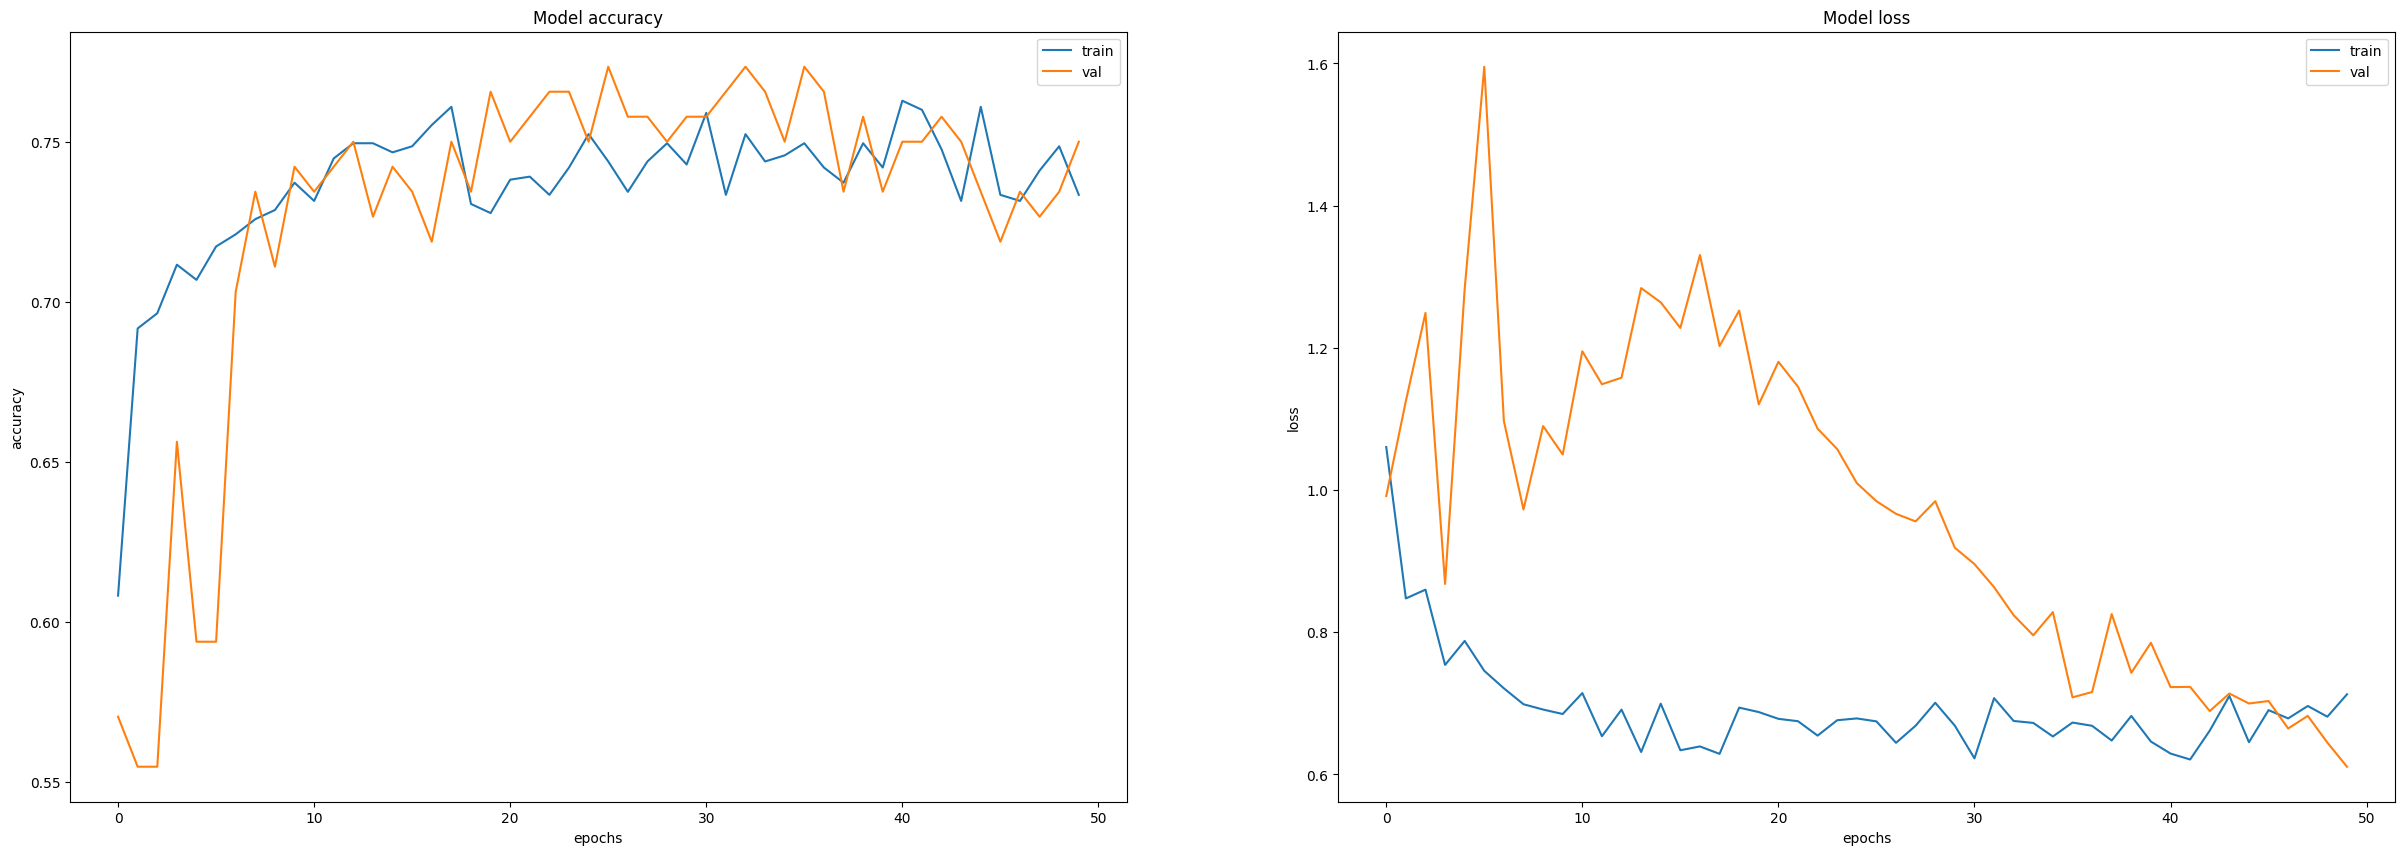

In [18]:
#plotting losses
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(30, 10))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model.history.history[metric][:])
    ax[i].plot(model.history.history["val_" + metric][:])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [24]:
!ls ./snapshots2

best_weight001.h5  best_weight033.h5  best_weight043.h5  best_weight050.h5
best_weight004.h5  best_weight034.h5  best_weight047.h5
best_weight032.h5  best_weight036.h5  best_weight049.h5


5/5 [==============================] - 4s 137ms/step


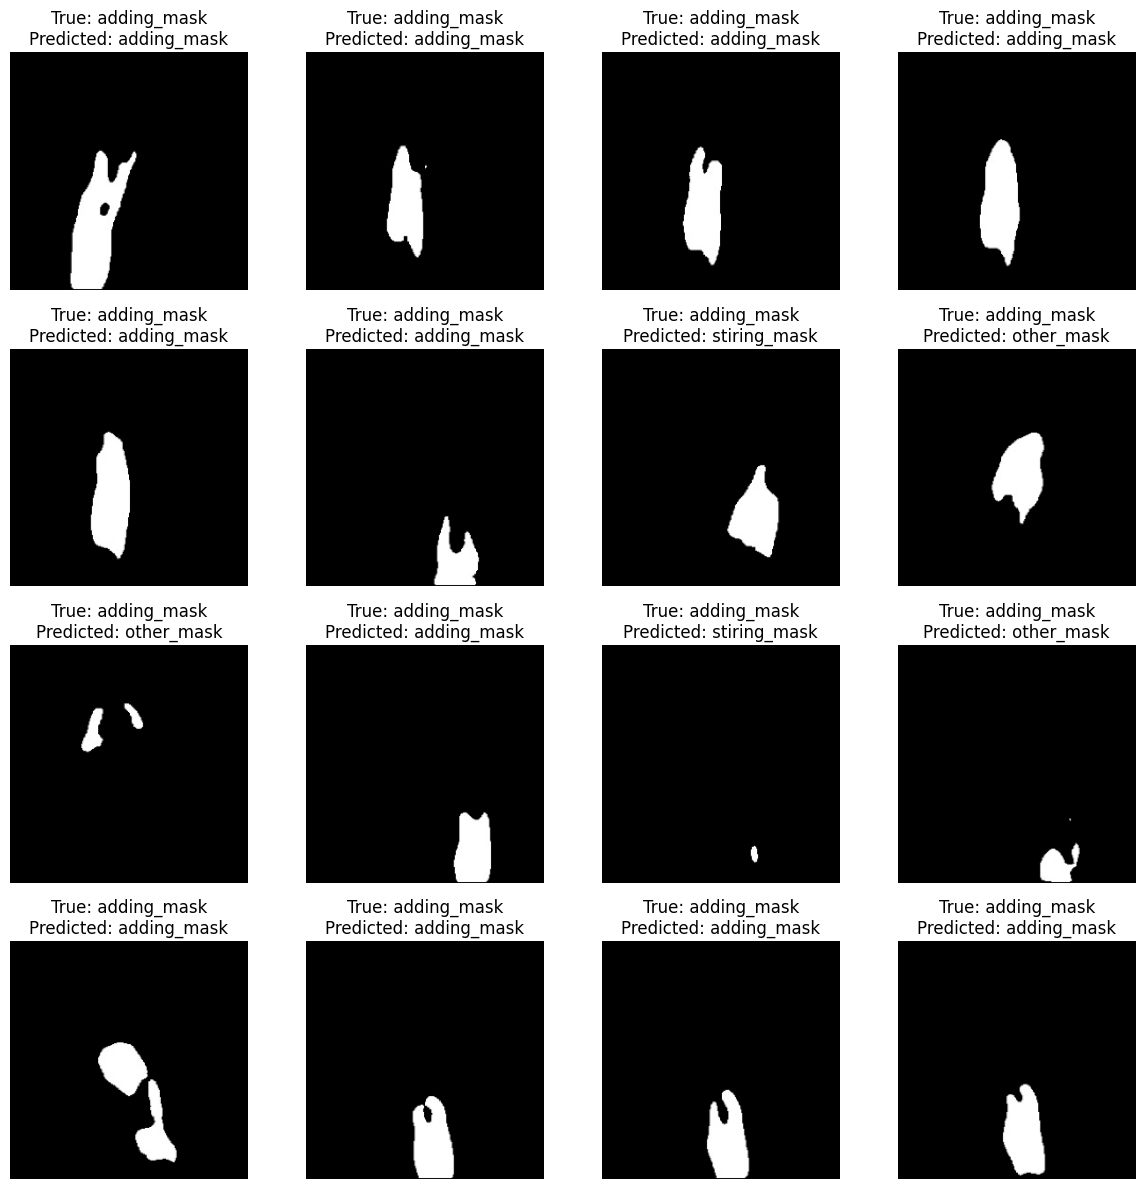

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ...

# Display test set results
class_labels = list(test_generator.class_indices.keys())

# Collect images and true labels for display
images, true_labels = [], []
for index in range(test_generator.samples):
    image_path = test_generator.filepaths[index]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    true_label = class_labels[test_generator.classes[index]]
    images.append(cv2.resize(image, (224, 224)))  # Resize the image to (224, 224)
    true_labels.append(true_label)

# Preprocess the images and run inference
processed_images = test_datagen.flow(np.array(images), batch_size=len(images), shuffle=False).next()
predictions = model.predict(processed_images)

# Display the images with predictions
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    predicted_label = class_labels[np.argmax(predictions[i])]
    ax.set_title(f'True: {true_labels[i]}\nPredicted: {predicted_label}')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [30]:
import numpy as np
from sklearn.metrics import precision_score, recall_score




# Make predictions on the test set
test_predictions = model.predict(test_generator)
test_labels = test_generator.classes

# Calculate precision and recall for each class
class_names = list(test_generator.class_indices.keys())
precision = precision_score(test_labels, np.argmax(test_predictions, axis=1), average=None)
recall = recall_score(test_labels, np.argmax(test_predictions, axis=1), average=None)

# Print precision and recall for each class
for i in range(len(class_names)):
    print(f'Class: {class_names[i]} - Precision: {precision[i]}, Recall: {recall[i]}')


5/5 [==============================] - 0s 56ms/step
Class: adding_mask - Precision: 0.75, Recall: 0.7894736842105263
Class: other_mask - Precision: 0.7303370786516854, Recall: 0.8666666666666667
Class: stiring_mask - Precision: 0.6, Recall: 0.23076923076923078


### We can see that our model is strugging with stirring class as the masked data for stirring class was not very clearly segmented but performs very well for adding ingrident action
